TC
kurtosis = 651.36156, transform_lambda = 0.02695, transformed_kurtosis= 3.20672
TG
kurtosis = 6.39116, transform_lambda = 0.00331, transformed_kurtosis= -0.01228
Scr
kurtosis = 177.08954, transform_lambda = -0.06684, transformed_kurtosis= 8.65833
BUN
kurtosis = 145.43208, transform_lambda = 0.25915, transformed_kurtosis= 8.31768
ALT
kurtosis = 66.37848, transform_lambda = 0.02885, transformed_kurtosis= 0.22401
AST
kurtosis = 68.93225, transform_lambda = 0.08055, transformed_kurtosis= 5.60707
FPG
kurtosis = 12.44533, transform_lambda = -1.09219, transformed_kurtosis= 2.71663
DBP
kurtosis = 2.13387, transform_lambda = -1.32449, transformed_kurtosis= -0.34798
SBP
kurtosis = -0.15300, transform_lambda = -0.91531, transformed_kurtosis= -0.15946


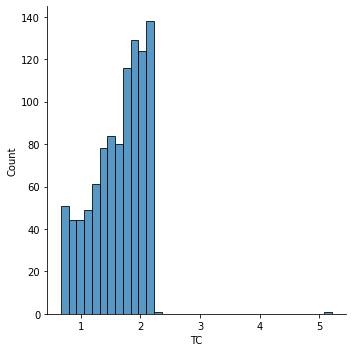

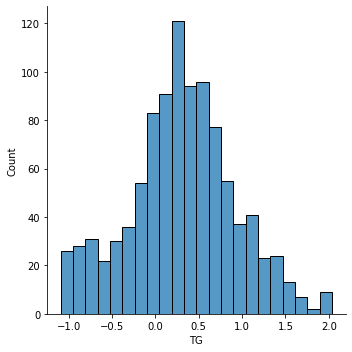

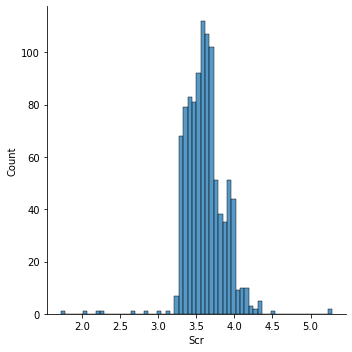

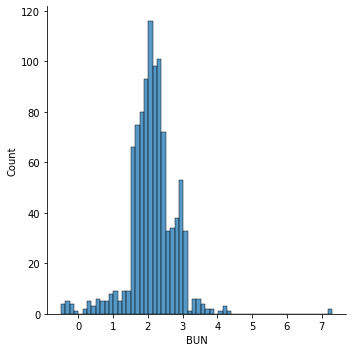

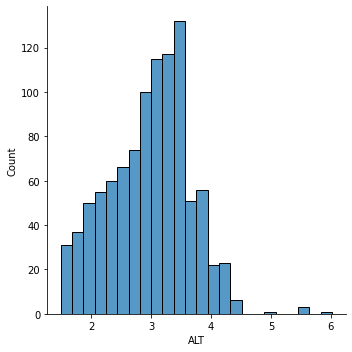

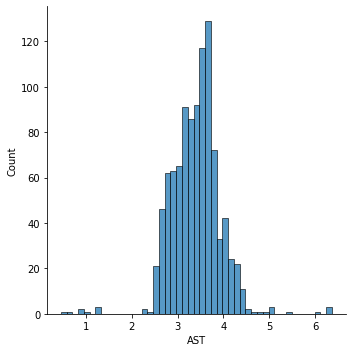

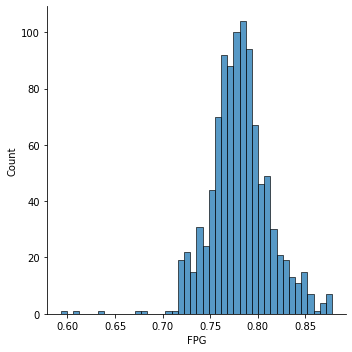

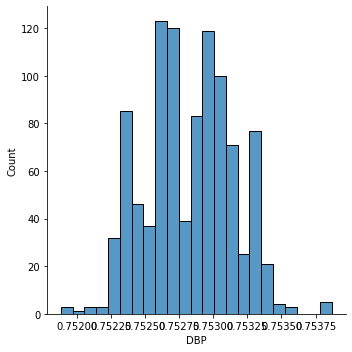

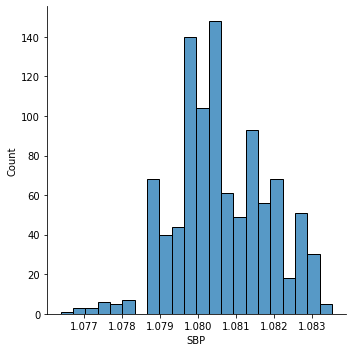

In [1]:
import numpy as np
import pandas as pd
import warnings
import json

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, ShuffleSplit

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from xgboost import plot_importance
import seaborn as sns
import scipy.stats as st

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

df = pd.read_csv("../data_synthesize/out/correlated_attribute_mode/sythetic_data.csv")
data =df.values

from scipy.optimize import minimize_scalar
xtotrans = ['TC', 'TG', 'Scr', 'BUN', 'ALT', 'AST', 'FPG', 'DBP', 'SBP']
for x in xtotrans:
    print(x)
    xt, namda = st.boxcox(x = df[x], optimizer=minimize_scalar)
    #print(res)
    
    print("kurtosis = %.5f, transform_lambda = %.5f, transformed_kurtosis= %.5f" %( st.kurtosis(df[x]), namda, st.kurtosis(xt)))
    df[x] = xt
    sns.displot(df[x])


Y = df["Outcome"].values
X = df[['Gender', 'Age', 'Height', 'Weight', 'BMI', 'Hypertension',
       'SBP', 'DBP', 'PR', 'Drink', 'Smoke', 'FPG', 'AST', 'ALT', 'BUN', 'Scr',
       'TG', 'TC']].values
names = ['Gender', 'Age', 'Height', 'Weight', 'BMI', 'Hypertension',
       'SBP', 'DBP', 'PR', 'Drink', 'Smoke', 'FPG', 'AST', 'ALT', 'BUN', 'Scr',
       'TG', 'TC']


sc = 'f1_macro'

In [3]:
import numpy as np
import pandas as pd
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

clfrf = RandomForestClassifier(n_estimators=20, 
                            max_depth= 19, 
                            max_features= 6, 
                            min_samples_leaf=1, 
                            min_samples_split=5, 
                            bootstrap=False)

clfSVC =  SVC(C= 10, kernel = 'rbf', gamma=0.01, probability=True)

clfGBDT = GradientBoostingClassifier(n_estimators=25, 
                                max_depth= 19,
                                 max_features= 9, 
                                 min_samples_leaf=1, 
                                 min_samples_split=5)

clfXGBT = XGBClassifier(n_estimators=60, max_depth= 8, learning_rate= 0.1)

df_weights = pd.read_csv("../Weight_new.csv")

print(df_weights[df_weights.columns[0]])
#df_weights = df_weights.drop([df_weights.columns[0],df_weights.columns[-1]], axis= 1)
df_weights = df_weights.drop([df_weights.columns[0]], axis= 1)


0      RF
1     SVM
2    GBDT
3     XGB
Name: blank, dtype: object


In [4]:
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, ShuffleSplit

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
max_score = 0
max_weights = []
for index, col in tqdm(df_weights.iteritems()):
    #print(col)
    clf_weights = col.values[:4]*10
    print(clf_weights)
    vclf = VotingClassifier(estimators=[('rf',clfrf),('svc',clfSVC),('gbdt',clfGBDT),('xgbt',clfXGBT)], voting='soft', weights= clf_weights)
    score = cross_val_score(vclf, X, Y, cv=ShuffleSplit(10, test_size = .1, train_size = .9), n_jobs = 8, scoring=sc)
    print(score)
    print(sum(score)/len(score))

    if max_score<(sum(score)/len(score)):
        max_weights = clf_weights
        max_score = sum(score)/len(score)

print(max_score, max_weights)

    

0it [00:00, ?it/s]

[1. 1. 3. 5.]


1it [00:03,  3.94s/it]

[0.88095238 0.89035088 0.89964158 0.86431479 0.80811404 0.93865783
 0.80747016 0.76689977 0.89964158 0.82430058]
0.85803435763714
[1. 1. 4. 4.]


2it [00:06,  3.22s/it]

[0.87004548 0.87599206 0.85974755 0.80747016 0.8895841  0.79705733
 0.8542982  0.88706945 0.88156336 0.85883682]
0.8581664516700519
[1. 1. 5. 3.]


3it [00:11,  4.01s/it]

[0.83552632 0.89964158 0.95698925 0.83060418 0.86504723 0.85185185
 0.85431235 0.82430058 0.83060418 0.89572471]
0.8644602231057835
[1. 2. 2. 5.]


4it [00:14,  3.38s/it]

[0.88839286 0.77781069 0.80743594 0.87316083 0.85883682 0.80747016
 0.86504723 0.81916817 0.79140592 0.8895841 ]
0.8378312723818706
[1. 2. 3. 4.]


5it [00:16,  3.14s/it]

[0.89900123 0.91744309 0.87096774 0.82242516 0.83552632 0.88714734
 0.87858184 0.8139881  0.87096774 0.87836194]
0.8674410500992027
[1. 2. 4. 3.]


6it [00:20,  3.35s/it]

[0.84       0.82892486 0.89035088 0.89181392 0.90286547 0.87096774
 0.83669026 0.76359338 0.82430058 0.80260561]
0.8452112689905894
[1. 2. 5. 2.]


7it [00:22,  3.04s/it]

[0.84051037 0.81333333 0.80952381 0.86504723 0.81968987 0.847793
 0.83001457 0.79705733 0.89852867 0.90539262]
0.8426890795959985
[1. 3. 1. 5.]


8it [00:25,  2.92s/it]

[0.88095238 0.79705733 0.80747016 0.87006237 0.80573094 0.93420187
 0.78902954 0.84703101 0.80058291 0.83552632]
0.8367644820338185
[1. 3. 2. 4.]


9it [00:28,  2.79s/it]

[0.87004548 0.88156336 0.78494624 0.83333333 0.8542982  0.86666667
 0.8629386  0.85133126 0.88714734 0.79950466]
0.8491775138715223
[1. 3. 3. 3.]


10it [00:34,  3.87s/it]

[0.8331408  0.91776316 0.78494624 0.87944545 0.81968987 0.82430058
 0.85881145 0.90788262 0.76110846 0.87836194]
0.8465450557545993
[1. 3. 4. 2.]


11it [00:37,  3.67s/it]

[0.83669026 0.82242516 0.8159735  0.88714734 0.85524411 0.89964158
 0.875      0.87944545 0.83552632 0.81362007]
0.8520713781018017
[1. 3. 5. 1.]


12it [00:39,  3.21s/it]

[0.8369906  0.84407484 0.84415584 0.88839286 0.87026772 0.90539262
 0.82517483 0.80626781 0.88156336 0.78571429]
0.848799476261666
[1. 4. 1. 4.]


13it [00:42,  3.05s/it]

[0.82517483 0.78683386 0.7972699  0.77628635 0.87006237 0.82517483
 0.88714734 0.86206897 0.86206897 0.86777257]
0.8359859966293021
[1. 4. 2. 3.]


14it [00:44,  2.84s/it]

[0.89262157 0.81808732 0.81362007 0.81333333 0.8629386  0.80747016
 0.7960373  0.85077102 0.85133126 0.84229391]
0.8348504525439784
[1. 4. 3. 2.]


15it [00:47,  2.71s/it]

[0.85524411 0.83552632 0.91015274 0.86194202 0.90788262 0.85666507
 0.81760902 0.87836194 0.87599206 0.80058291]
0.8599958808882165
[1. 4. 4. 1.]


16it [00:51,  3.30s/it]

[0.93420187 0.87006237 0.83060418 0.91776316 0.88706945 0.89262157
 0.88706945 0.84051037 0.85411289 0.83060418]
0.8744619486785261
[1. 5. 1. 3.]


17it [00:55,  3.37s/it]

[0.8895841  0.87944545 0.91015274 0.80237154 0.90539262 0.80260561
 0.81191223 0.84703101 0.84407484 0.847793  ]
0.8540363136888771
[1. 5. 2. 2.]


18it [00:59,  3.61s/it]

[0.82430058 0.84703101 0.86666667 0.81333333 0.80506823 0.89964158
 0.8015873  0.83552632 0.88156336 0.83060418]
0.8405322554734875
[1. 5. 3. 1.]


19it [01:02,  3.49s/it]

[0.86206897 0.8960499  0.83060418 0.84668003 0.87858184 0.85431235
 0.847793   0.80573094 0.82892486 0.847793  ]
0.8498539056013266
[2. 1. 2. 5.]


20it [01:05,  3.28s/it]

[0.82430058 0.91015274 0.92203742 0.81921847 0.83706118 0.86504723
 0.92       0.8629386  0.84373122 0.89035088]
0.8694838312036299
[2. 1. 3. 4.]


21it [01:07,  2.94s/it]

[0.87858184 0.85077102 0.83126246 0.85524411 0.87484355 0.86504723
 0.88156336 0.847793   0.81362007 0.9026561 ]
0.8601382746467591
[2. 1. 4. 3.]


22it [01:10,  2.95s/it]

[0.81921847 0.85714286 0.78683386 0.86777257 0.81191223 0.82620786
 0.80747016 0.86449864 0.86206897 0.91585527]
0.8418980869844113
[2. 1. 5. 2.]


23it [01:13,  2.79s/it]

[0.84668003 0.85883682 0.87006237 0.76990336 0.89631166 0.85431235
 0.88448209 0.84668003 0.77023922 0.86666667]
0.8464174605629744
[2. 2. 1. 5.]


24it [01:19,  3.78s/it]

[0.77628635 0.84930681 0.8960499  0.84373122 0.8331408  0.81921847
 0.9047619  0.84407484 0.81808732 0.81921847]
0.8403876084017006
[2. 2. 2. 4.]


25it [01:22,  3.51s/it]

[0.85883682 0.76689977 0.88095238 0.86206897 0.8331408  0.76
 0.81808732 0.83388704 0.91015274 0.8331408 ]
0.8357166637328465
[2. 2. 3. 3.]


26it [01:25,  3.47s/it]

[0.84229391 0.7960373  0.87599206 0.8542982  0.80260561 0.81333333
 0.91585527 0.8125     0.80237154 0.83706118]
0.8352348397374956
[2. 2. 4. 2.]


27it [01:27,  3.16s/it]

[0.86638672 0.86504723 0.81333333 0.88851728 0.8125     0.87096774
 0.85133126 0.85524411 0.9026561  0.89964158]
0.8625625350590227
[2. 2. 5. 1.]


28it [01:30,  2.96s/it]

[0.80743594 0.85881145 0.85431235 0.78494624 0.88095238 0.83333333
 0.86668642 0.81362007 0.85666507 0.92      ]
0.8476763252250231
[2. 3. 1. 4.]


29it [01:33,  3.11s/it]

[0.81916817 0.80626781 0.88344988 0.93224932 0.88692899 0.81916817
 0.87316083 0.86206897 0.83552632 0.84402852]
0.8562016984685389
[2. 3. 2. 3.]


30it [01:36,  2.99s/it]

[0.88511029 0.85883682 0.87026772 0.85133126 0.875      0.86194202
 0.84229391 0.91709501 0.81362007 0.82892486]
0.8604421952502206
[2. 3. 3. 2.]


31it [01:39,  2.86s/it]

[0.81617647 0.81333333 0.82430058 0.84930681 0.75612887 0.87858184
 0.89631166 0.82638889 0.91258741 0.89964158]
0.8472757434966403
[2. 3. 4. 1.]


32it [01:42,  2.98s/it]

[0.875      0.84229391 0.84051037 0.90625    0.90788262 0.84373122
 0.84373122 0.84938014 0.86666667 0.87096774]
0.8646413875111858
[2. 4. 1. 3.]


33it [01:44,  2.86s/it]

[0.86668642 0.81191223 0.87255243 0.87316083 0.88851728 0.84407484
 0.8960499  0.88706945 0.83706118 0.85133126]
0.8628415811230841
[2. 4. 2. 2.]


34it [01:48,  2.94s/it]

[0.85524411 0.85524411 0.87026772 0.87484355 0.93224932 0.83333333
 0.83755686 0.88156336 0.80747016 0.90079365]
0.8648566180023443
[2. 4. 3. 1.]


35it [01:50,  2.79s/it]

[0.90286547 0.88706945 0.86194202 0.8629386  0.92987377 0.88156336
 0.78902954 0.76689977 0.87316083 0.8629386 ]
0.8618281400811172
[2. 5. 1. 2.]


36it [01:56,  3.61s/it]

[0.89852867 0.80811404 0.8331408  0.79674797 0.8369906  0.87026772
 0.76990336 0.78902954 0.7960373  0.88344988]
0.8282209862334982
[2. 5. 2. 1.]


37it [01:59,  3.48s/it]

[0.87484355 0.77628635 0.80237154 0.84051037 0.875      0.9026561
 0.90788262 0.87096774 0.85431235 0.8331408 ]
0.8537971430011648
[3. 1. 1. 5.]


38it [02:03,  3.84s/it]

[0.84615385 0.86504723 0.83166872 0.85524411 0.87464387 0.88156336
 0.82242516 0.8542982  0.8159735  0.88095238]
0.8527970402021152
[3. 1. 2. 4.]


39it [02:06,  3.59s/it]

[0.84       0.87004548 0.87599206 0.82242516 0.84051037 0.84229391
 0.92559524 0.86666667 0.7972699  0.84170059]
0.8522499380168915
[3. 1. 3. 3.]


40it [02:10,  3.57s/it]

[0.79705733 0.87858184 0.90958409 0.8960499  0.79296066 0.9047619
 0.88344988 0.85666507 0.91776316 0.87484355]
0.8711717387127559
[3. 1. 4. 2.]


41it [02:13,  3.36s/it]

[0.82242516 0.83333333 0.90079365 0.81921847 0.91258741 0.91341991
 0.8629386  0.88706945 0.85431235 0.87878788]
0.868488622443239
[3. 1. 5. 1.]


42it [02:15,  3.11s/it]

[0.86206897 0.86206897 0.87944545 0.90788262 0.82430058 0.89852867
 0.82905983 0.84407484 0.83552632 0.82905983]
0.8572016061029432
[3. 2. 1. 4.]


43it [02:18,  2.92s/it]

[0.88714734 0.84229391 0.83166872 0.84703101 0.90286547 0.78571429
 0.85119048 0.85524411 0.93420187 0.89181392]
0.8629171107523469
[3. 2. 2. 3.]


44it [02:20,  2.73s/it]

[0.83001457 0.8331408  0.81362007 0.8895841  0.90788262 0.88448209
 0.86638672 0.8629386  0.88156336 0.91015274]
0.8679765671779368
[3. 2. 3. 2.]


45it [02:23,  2.66s/it]

[0.87316083 0.91530209 0.8629386  0.89852867 0.8125     0.86206897
 0.8895841  0.76       0.75328947 0.7741389 ]
0.8401511627308811
[3. 2. 4. 1.]


46it [02:25,  2.54s/it]

[0.81299673 0.84       0.88839286 0.84       0.87096774 0.87484355
 0.91412097 0.80260561 0.91776316 0.88448209]
0.8646172706336879
[3. 3. 1. 3.]


47it [02:28,  2.58s/it]

[0.8331408  0.85119048 0.85133126 0.89964158 0.8369906  0.82638889
 0.81916817 0.88448209 0.89385541 0.87836194]
0.8574551218827349
[3. 3. 2. 2.]


48it [02:31,  2.71s/it]

[0.82517483 0.85883682 0.7960373  0.94172494 0.88692899 0.85431235
 0.9271491  0.79564852 0.82892486 0.84375   ]
0.8558487699500746
[3. 3. 3. 1.]


49it [02:33,  2.60s/it]

[0.91015274 0.84668003 0.83552632 0.91222571 0.86504723 0.90625
 0.83706118 0.88312295 0.80811404 0.8629386 ]
0.8667118790303805
[3. 4. 1. 2.]


50it [02:35,  2.52s/it]

[0.80058291 0.77023922 0.91776316 0.88706945 0.81333333 0.83001457
 0.82242516 0.84051037 0.84229391 0.84703101]
0.8371263096213593
[3. 4. 2. 1.]


51it [02:38,  2.60s/it]

[0.84930681 0.80506823 0.90539262 0.90253411 0.875      0.82517483
 0.83405244 0.81916817 0.81362007 0.84407484]
0.8473392125099775
[3. 5. 1. 1.]


52it [02:40,  2.52s/it]

[0.77818108 0.91776316 0.875      0.79140592 0.85133126 0.80747016
 0.88714734 0.85431235 0.73776224 0.82242516]
0.8322798678107033
[4. 1. 1. 4.]


53it [02:43,  2.47s/it]

[0.89964158 0.92       0.89852867 0.86666667 0.88692899 0.86504723
 0.84229391 0.81299673 0.86666667 0.79674797]
0.8655518402653548
[4. 1. 2. 3.]


54it [02:45,  2.53s/it]

[0.8629386  0.82892486 0.8542982  0.81191223 0.94926433 0.79319853
 0.78738483 0.90539262 0.83706118 0.90539262]
0.8535767996801813
[4. 1. 3. 2.]


55it [02:48,  2.64s/it]

[0.85133126 0.88156336 0.90286547 0.80952381 0.90253411 0.8369906
 0.86449864 0.87096774 0.86431479 0.80743594]
0.8592025723478158
[4. 1. 4. 1.]


56it [02:51,  2.67s/it]

[0.89572471 0.84       0.91015274 0.90539262 0.93989662 0.85883682
 0.8369906  0.8331408  0.86206897 0.81333333]
0.869553720971058
[4. 2. 1. 3.]


57it [02:54,  2.64s/it]

[0.9271491  0.89181392 0.83637214 0.88511029 0.89852867 0.89333333
 0.87316083 0.86668642 0.87836194 0.93046864]
0.888098528211535
[4. 2. 2. 2.]


58it [02:58,  3.03s/it]

[0.86666667 0.91744309 0.83706118 0.88714734 0.90788262 0.92
 0.83060418 0.85524411 0.82892486 0.84373122]
0.8694705254776149
[4. 2. 3. 1.]


59it [03:00,  2.95s/it]

[0.88095238 0.93989662 0.86206897 0.78494624 0.82892486 0.83637214
 0.88095238 0.87836194 0.847793   0.8895841 ]
0.8629852620608874
[4. 3. 1. 2.]


60it [03:03,  2.79s/it]

[0.8369906  0.82174688 0.84407484 0.7972699  0.8369906  0.8125
 0.83062331 0.88706945 0.84       0.81617647]
0.8323442046313986
[4. 3. 2. 1.]


61it [03:06,  2.82s/it]

[0.80058291 0.89333333 0.88393301 0.82638889 0.83552632 0.8125
 0.78070175 0.8331408  0.73922381 0.847793  ]
0.8253123825956074
[4. 4. 1. 1.]


62it [03:08,  2.70s/it]

[0.8629386  0.80952381 0.8331408  0.86213235 0.8629386  0.88706945
 0.90788262 0.84703101 0.81808732 0.93046864]
0.8621213197789721
[5. 1. 1. 3.]


63it [03:10,  2.64s/it]

[0.87858184 0.7972699  0.83001457 0.83706118 0.87836194 0.87858184
 0.8895841  0.85714286 0.88706945 0.85524411]
0.8588911780735231
[5. 1. 2. 2.]


64it [03:14,  2.82s/it]

[0.85881145 0.8331408  0.76689977 0.84703101 0.847793   0.8542982
 0.86504723 0.83126246 0.9259369  0.83706118]
0.8467282003369647
[5. 1. 3. 1.]


65it [03:17,  2.82s/it]

[0.88393301 0.81916817 0.85881145 0.80747016 0.82638889 0.8895841
 0.88344988 0.86668642 0.83552632 0.83706118]
0.8508079574536191
[5. 2. 1. 2.]


66it [03:19,  2.74s/it]

[0.86666667 0.87316083 0.82309235 0.85133126 0.8960499  0.86449864
 0.81916817 0.81968987 0.87858184 0.76110846]
0.8453347979316991
[5. 2. 2. 1.]


67it [03:22,  2.77s/it]

[0.87858184 0.90788262 0.9259369  0.87599206 0.91585527 0.80811404
 0.89035088 0.87989955 0.87006237 0.87006237]
0.8822737889530259
[5. 3. 1. 1.]


68it [03:25,  3.02s/it]

[0.8369906  0.81921847 0.83060418 0.87836194 0.88156336 0.87484355
 0.87858184 0.79946524 0.84375    0.87255243]
0.851593160419805
0.888098528211535 [4. 2. 1. 3.]


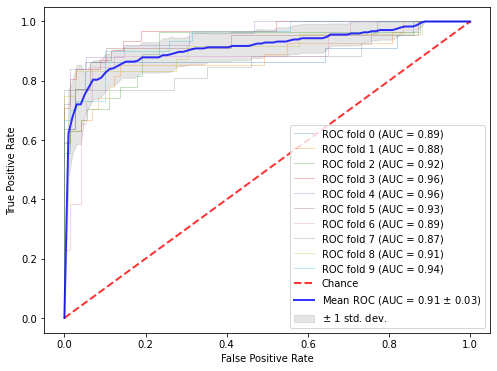

In [5]:
from numpy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

#if len(Y)
n_classes = Y.shape
cv = ShuffleSplit(10, test_size = .1, train_size = .9)
classifier = VotingClassifier(estimators=[('rf',clfrf),('svc',clfSVC),('gbdt',clfGBDT),('xgbt',clfXGBT)], voting='soft', weights= max_weights)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))
i = 0
for train, test in cv.split(X, Y):
    y_score = classifier.fit(X[train], Y[train]).predict_proba(X[test])
    # y_score.shape==(75, 3)
    #if len(y_score.shape)<= 1 :
    #    y_score = y_score[:, np.newaxis]
    # 为每个类别计算ROC曲线和AUC
    fpr, tpr, thresholds = roc_curve(Y[test], y_score[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [6]:
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, ShuffleSplit

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
max_score = 0
max_weights = []
for index, col in tqdm(df_weights.iteritems()):
    #print(col)
    clf_weights = col.values[:4]*10
    print(clf_weights)
    vclf = VotingClassifier(estimators=[('rf',clfrf),('svc',clfSVC),('gbdt',clfGBDT),('xgbt',clfXGBT)], voting='hard', weights= clf_weights)
    score = cross_val_score(vclf, X, Y, cv=ShuffleSplit(10, test_size = .1, train_size = .9), n_jobs = 6)
    print(score)
    print(sum(score)/len(score))

    if max_score<(sum(score)/len(score)):
        max_weights = clf_weights
        max_score = sum(score)/len(score)

print(max_score, max_weights)

    

0it [00:00, ?it/s]

[1. 1. 3. 5.]


1it [00:03,  3.60s/it]

[0.86 0.87 0.91 0.89 0.98 0.83 0.85 0.9  0.9  0.93]
0.892
[1. 1. 4. 4.]


2it [00:07,  3.67s/it]

[0.92 0.87 0.85 0.95 0.89 0.88 0.94 0.85 0.89 0.84]
0.8879999999999999
[1. 1. 5. 3.]


3it [00:10,  3.46s/it]

[0.88 0.95 0.96 0.83 0.89 0.89 0.9  0.85 0.91 0.9 ]
0.8959999999999999
[1. 2. 2. 5.]


4it [00:13,  3.11s/it]

[0.85 0.88 0.88 0.88 0.91 0.94 0.86 0.88 0.9  0.89]
0.8870000000000001
[1. 2. 3. 4.]


5it [00:15,  3.01s/it]

[0.9  0.94 0.9  0.92 0.93 0.92 0.88 0.86 0.92 0.89]
0.906
[1. 2. 4. 3.]


6it [00:18,  2.83s/it]

[0.87 0.9  0.9  0.88 0.79 0.83 0.86 0.9  0.91 0.85]
0.8690000000000001
[1. 2. 5. 2.]


7it [00:21,  2.76s/it]

[0.9  0.85 0.92 0.92 0.89 0.9  0.91 0.89 0.8  0.92]
0.89
[1. 3. 1. 5.]


8it [00:23,  2.80s/it]

[0.79 0.9  0.9  0.9  0.86 0.91 0.8  0.86 0.9  0.94]
0.876
[1. 3. 2. 4.]


9it [00:28,  3.21s/it]

[0.89 0.94 0.94 0.93 0.89 0.91 0.93 0.9  0.89 0.88]
0.9100000000000001
[1. 3. 3. 3.]


10it [00:30,  3.13s/it]

[0.88 0.95 0.93 0.87 0.93 0.85 0.92 0.9  0.9  0.85]
0.898
[1. 3. 4. 2.]


11it [00:34,  3.13s/it]

[0.87 0.96 0.89 0.78 0.88 0.91 0.87 0.89 0.91 0.87]
0.883
[1. 3. 5. 1.]


12it [00:37,  3.27s/it]

[0.92 0.85 0.88 0.87 0.84 0.92 0.85 0.93 0.87 0.91]
0.884
[1. 4. 1. 4.]


13it [00:40,  3.11s/it]

[0.91 0.91 0.89 0.87 0.9  0.89 0.9  0.93 0.93 0.85]
0.898
[1. 4. 2. 3.]


14it [00:43,  3.01s/it]

[0.89 0.9  0.87 0.94 0.91 0.93 0.91 0.83 0.87 0.86]
0.8909999999999998
[1. 4. 3. 2.]


15it [00:47,  3.38s/it]

[0.91 0.9  0.87 0.88 0.9  0.86 0.88 0.91 0.89 0.88]
0.8880000000000001
[1. 4. 4. 1.]


16it [00:50,  3.14s/it]

[0.86 0.91 0.89 0.91 0.86 0.91 0.88 0.89 0.9  0.82]
0.883
[1. 5. 1. 3.]


17it [00:54,  3.45s/it]

[0.81 0.85 0.8  0.9  0.81 0.87 0.84 0.82 0.86 0.78]
0.834
[1. 5. 2. 2.]


18it [00:58,  3.59s/it]

[0.75 0.78 0.8  0.85 0.85 0.89 0.77 0.79 0.86 0.88]
0.8220000000000001
[1. 5. 3. 1.]


19it [01:02,  3.94s/it]

[0.82 0.9  0.83 0.8  0.84 0.78 0.82 0.78 0.8  0.88]
0.825
[2. 1. 2. 5.]


20it [01:05,  3.65s/it]

[0.87 0.86 0.86 0.88 0.87 0.96 0.87 0.89 0.88 0.96]
0.8899999999999999
[2. 1. 3. 4.]


21it [01:10,  3.81s/it]

[0.87 0.95 0.93 0.94 0.89 0.87 0.88 0.92 0.88 0.86]
0.899
[2. 1. 4. 3.]


22it [01:13,  3.68s/it]

[0.89 0.94 0.89 0.92 0.89 0.88 0.9  0.88 0.91 0.88]
0.898
[2. 1. 5. 2.]


23it [01:17,  3.68s/it]

[0.85 0.92 0.89 0.84 0.83 0.89 0.88 0.92 0.89 0.85]
0.876
[2. 2. 1. 5.]


24it [01:19,  3.43s/it]

[0.86 0.87 0.9  0.88 0.87 0.82 0.91 0.9  0.87 0.88]
0.8760000000000001
[2. 2. 2. 4.]


25it [01:23,  3.41s/it]

[0.92 0.94 0.9  0.85 0.93 0.84 0.94 0.88 0.94 0.88]
0.9020000000000001
[2. 2. 3. 3.]


26it [01:25,  3.19s/it]

[0.9  0.8  0.91 0.93 0.93 0.9  0.9  0.9  0.86 0.89]
0.8920000000000001
[2. 2. 4. 2.]


27it [01:28,  3.00s/it]

[0.9  0.94 0.87 0.83 0.92 0.91 0.85 0.87 0.88 0.86]
0.883
[2. 2. 5. 1.]


28it [01:31,  3.12s/it]

[0.9  0.92 0.94 0.88 0.92 0.84 0.93 0.91 0.87 0.88]
0.899
[2. 3. 1. 4.]


29it [01:34,  3.06s/it]

[0.91 0.91 0.89 0.93 0.93 0.88 0.91 0.9  0.93 0.94]
0.913
[2. 3. 2. 3.]


30it [01:37,  2.93s/it]

[0.91 0.9  0.9  0.86 0.89 0.9  0.88 0.87 0.86 0.83]
0.8800000000000001
[2. 3. 3. 2.]


31it [01:40,  2.86s/it]

[0.95 0.87 0.89 0.93 0.87 0.88 0.95 0.85 0.86 0.91]
0.8959999999999999
[2. 3. 4. 1.]


32it [01:44,  3.22s/it]

[0.89 0.87 0.9  0.9  0.89 0.96 0.89 0.92 0.87 0.87]
0.8959999999999999
[2. 4. 1. 3.]


33it [01:47,  3.21s/it]

[0.9  0.89 0.93 0.88 0.95 0.92 0.89 0.9  0.96 0.9 ]
0.9119999999999999
[2. 4. 2. 2.]


34it [01:54,  4.43s/it]

[0.9  0.9  0.87 0.94 0.87 0.92 0.94 0.9  0.87 0.92]
0.9029999999999999
[2. 4. 3. 1.]


35it [01:57,  4.01s/it]

[0.91 0.92 0.87 0.89 0.92 0.9  0.9  0.86 0.91 0.92]
0.9000000000000001
[2. 5. 1. 2.]


36it [02:00,  3.73s/it]

[0.83 0.81 0.78 0.83 0.85 0.8  0.88 0.79 0.85 0.85]
0.827
[2. 5. 2. 1.]


37it [02:04,  3.59s/it]

[0.84 0.86 0.88 0.84 0.8  0.81 0.83 0.84 0.77 0.86]
0.8329999999999999
[3. 1. 1. 5.]


38it [02:07,  3.43s/it]

[0.85 0.84 0.88 0.9  0.91 0.89 0.92 0.94 0.85 0.83]
0.8809999999999999
[3. 1. 2. 4.]


39it [02:09,  3.20s/it]

[0.85 0.84 0.87 0.84 0.93 0.89 0.95 0.87 0.86 0.92]
0.882
[3. 1. 3. 3.]


40it [02:12,  3.01s/it]

[0.88 0.88 0.95 0.81 0.88 0.93 0.93 0.95 0.85 0.85]
0.891
[3. 1. 4. 2.]


41it [02:14,  2.88s/it]

[0.93 0.84 0.9  0.92 0.87 0.85 0.88 0.83 0.86 0.92]
0.8800000000000001
[3. 1. 5. 1.]


42it [02:18,  3.09s/it]

[0.88 0.91 0.91 0.94 0.9  0.89 0.87 0.92 0.87 0.9 ]
0.899
[3. 2. 1. 4.]


43it [02:21,  2.94s/it]

[0.95 0.9  0.87 0.9  0.89 0.93 0.93 0.85 0.85 0.91]
0.8979999999999999
[3. 2. 2. 3.]


44it [02:24,  2.94s/it]

[0.93 0.91 0.9  0.88 0.86 0.91 0.83 0.88 0.92 0.87]
0.889
[3. 2. 3. 2.]


45it [02:26,  2.93s/it]

[0.89 0.94 0.9  0.86 0.91 0.91 0.87 0.92 0.93 0.88]
0.9010000000000001
[3. 2. 4. 1.]


46it [02:29,  2.87s/it]

[0.9  0.84 0.91 0.92 0.91 0.9  0.9  0.91 0.92 0.91]
0.9020000000000001
[3. 3. 1. 3.]


47it [02:32,  2.73s/it]

[0.91 0.9  0.87 0.84 0.92 0.93 0.92 0.89 0.89 0.94]
0.901
[3. 3. 2. 2.]


48it [02:35,  2.80s/it]

[0.9  0.87 0.92 0.9  0.95 0.9  0.86 0.88 0.92 0.96]
0.9060000000000002
[3. 3. 3. 1.]


49it [02:37,  2.77s/it]

[0.9  0.87 0.88 0.94 0.88 0.95 0.88 0.93 0.89 0.91]
0.9029999999999999
[3. 4. 1. 2.]


50it [02:40,  2.76s/it]

[0.93 0.87 0.87 0.9  0.94 0.9  0.89 0.91 0.88 0.9 ]
0.899
[3. 4. 2. 1.]


51it [02:43,  2.98s/it]

[0.89 0.93 0.9  0.9  0.9  0.89 0.86 0.89 0.86 0.88]
0.89
[3. 5. 1. 1.]


52it [02:46,  2.96s/it]

[0.83 0.86 0.82 0.81 0.87 0.83 0.85 0.89 0.88 0.82]
0.8459999999999999
[4. 1. 1. 4.]


53it [02:49,  2.81s/it]

[0.89 0.83 0.9  0.9  0.9  0.92 0.9  0.95 0.93 0.92]
0.9040000000000001
[4. 1. 2. 3.]


54it [02:51,  2.74s/it]

[0.91 0.86 0.87 0.87 0.89 0.84 0.9  0.92 0.9  0.92]
0.8880000000000001
[4. 1. 3. 2.]


55it [02:55,  2.87s/it]

[0.88 0.93 0.89 0.91 0.9  0.89 0.89 0.9  0.88 0.9 ]
0.897
[4. 1. 4. 1.]


56it [03:00,  3.52s/it]

[0.9  0.93 0.85 0.9  0.9  0.87 0.91 0.89 0.88 0.92]
0.8950000000000001
[4. 2. 1. 3.]


57it [03:02,  3.19s/it]

[0.89 0.91 0.88 0.88 0.89 0.96 0.89 0.87 0.93 0.94]
0.9039999999999999
[4. 2. 2. 2.]


58it [03:05,  3.24s/it]

[0.93 0.92 0.83 0.87 0.88 0.89 0.89 0.92 0.87 0.87]
0.8869999999999999
[4. 2. 3. 1.]


59it [03:08,  3.01s/it]

[0.86 0.95 0.86 0.86 0.87 0.86 0.92 0.93 0.9  0.87]
0.8879999999999999
[4. 3. 1. 2.]


60it [03:11,  3.16s/it]

[0.91 0.91 0.88 0.89 0.88 0.91 0.91 0.89 0.85 0.9 ]
0.8930000000000001
[4. 3. 2. 1.]


61it [03:14,  3.13s/it]

[0.9  0.92 0.92 0.88 0.85 0.92 0.9  0.91 0.87 0.9 ]
0.897
[4. 4. 1. 1.]


62it [03:17,  3.00s/it]

[0.9  0.88 0.92 0.89 0.86 0.83 0.85 0.93 0.91 0.95]
0.892
[5. 1. 1. 3.]


63it [03:20,  2.85s/it]

[0.95 0.87 0.88 0.91 0.89 0.82 0.92 0.88 0.87 0.86]
0.885
[5. 1. 2. 2.]


64it [03:23,  2.98s/it]

[0.9  0.9  0.89 0.89 0.85 0.87 0.89 0.87 0.84 0.92]
0.882
[5. 1. 3. 1.]


65it [03:26,  2.87s/it]

[0.9  0.87 0.87 0.84 0.86 0.91 0.85 0.88 0.88 0.89]
0.875
[5. 2. 1. 2.]


66it [03:29,  3.10s/it]

[0.88 0.9  0.91 0.91 0.92 0.92 0.89 0.89 0.91 0.87]
0.8999999999999998
[5. 2. 2. 1.]


67it [03:32,  2.92s/it]

[0.89 0.9  0.92 0.91 0.9  0.86 0.92 0.92 0.91 0.91]
0.9040000000000001
[5. 3. 1. 1.]


68it [03:35,  3.17s/it]

[0.83 0.85 0.92 0.9  0.91 0.9  0.9  0.9  0.86 0.92]
0.8890000000000002
0.913 [2. 3. 1. 4.]


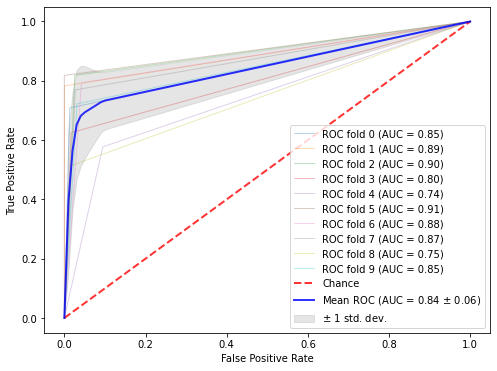

In [7]:
from numpy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

#if len(Y)
n_classes = Y.shape
cv = ShuffleSplit(10, test_size = .1, train_size = .9)
classifier = VotingClassifier(estimators=[('rf',clfrf),('svc',clfSVC),('gbdt',clfGBDT),('xgbt',clfXGBT)], voting='hard', weights= max_weights)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))
i = 0
for train, test in cv.split(X, Y):
    y_score = classifier.fit(X[train], Y[train]).predict(X[test])
    # y_score.shape==(75, 3)
    if len(y_score.shape)<= 1 :
        y_score = y_score[:, np.newaxis]
    # 为每个类别计算ROC曲线和AUC
    fpr, tpr, thresholds = roc_curve(Y[test], y_score[:, 0])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [8]:
y_score[:,0]

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1])

In [9]:
Y[test]

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1])